# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT Network dataset.



We have pip install mealpy each time because it is not a default python package ,and every time the runtime refreshes; the package is uninstalled.

In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Our main libraries used are:

*   Imblearn
*   Pandas
*   Matplot Lib
*   MealPy
*   Numpy
*   SKLearn
*   Tensorflow
*   Time



In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, FOX
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_Network_dataset/train_test_network.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('train_test_network.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

c:\Users\User1\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 50)            200       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 50)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 batch_normalization (Batch  (None, 20, 50)            200       
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 flatten (Flatten)           (None, 64)                0

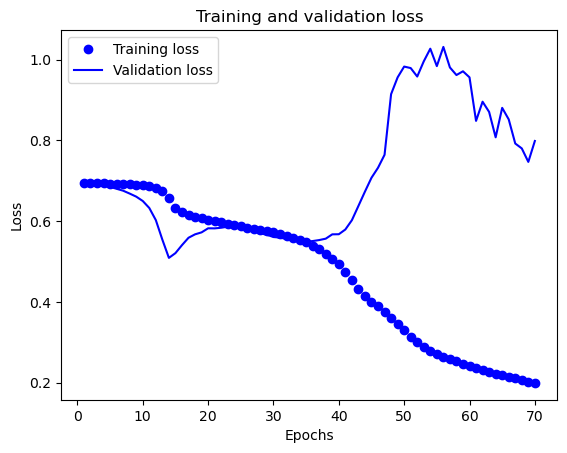

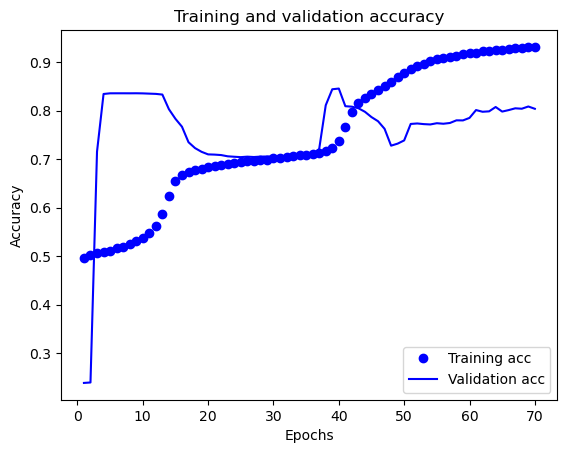


Classification Report
              precision    recall  f1-score   support

           0       0.66      0.34      0.45      4943
           1       0.82      0.95      0.88     16161

    accuracy                           0.80     21104
   macro avg       0.74      0.64      0.66     21104
weighted avg       0.79      0.80      0.78     21104


Confusion Matrix
[[ 1682  3261]
 [  871 15290]]


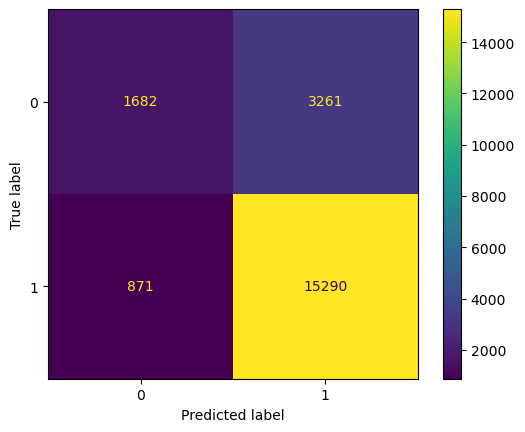

Time taken: 4457.1603 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units


The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.



2025/04/11 01:19:39 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: Solving single objective optimization problem.


Accuracy 0.08315563201904297
Accuracy 0.09372186660766602
Accuracy 0.24145936965942383
Accuracy 0.08362948894500732
Accuracy 0.16479510068893433
Accuracy 0.123904287815094
Accuracy 0.7585406303405762
Accuracy 0.28642499446868896
Accuracy 0.2693200707435608
Accuracy 0.08542996644973755
Accuracy 0.23714756965637207
Accuracy 0.0941956639289856
Accuracy 0.24145936965942383
Accuracy 0.15754562616348267
Accuracy 0.09092634916305542
Accuracy 0.2400379180908203
Accuracy 0.7585406303405762
Accuracy 0.09239518642425537
Accuracy 0.23762142658233643
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.24108028411865234
Accuracy 0.04652923345565796
Accuracy 0.12816870212554932
Accuracy 0.10153990983963013
Accuracy 0.24145936965942383
Accuracy 0.0939587950706482
Accuracy 0.14214640855789185
Accuracy 0.07448470592498779
Accuracy 0.16342097520828247
Accuracy 0.7585406303405762
Accuracy 0.0476190447807312
Accuracy 0.039943158626556396
Accuracy 0.7585406303405762
Accuracy 0.136270999908447

2025/04/12 01:48:32 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 1, Current best: 0.039943158626556396, Global best: 0.039943158626556396, Runtime: 24959.22323 seconds


Accuracy 0.7585406303405762
Accuracy 0.12418860197067261
Accuracy 0.24060648679733276
Accuracy 0.24145936965942383
Accuracy 0.09718078374862671
Accuracy 0.03193557262420654
Accuracy 0.07818055152893066
Accuracy 0.7585406303405762
Accuracy 0.11836057901382446
Accuracy 0.15394455194473267
Accuracy 0.03771620988845825
Accuracy 0.7585406303405762
Accuracy 0.24145936965942383
Accuracy 0.12745797634124756
Accuracy 0.7585406303405762
Accuracy 0.1393982172012329
Accuracy 0.7585406303405762
Accuracy 0.08808338642120361
Accuracy 0.0828239917755127
Accuracy 0.0738687515258789


2025/04/12 07:42:27 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 2, Current best: 0.03193557262420654, Global best: 0.03193557262420654, Runtime: 21235.17911 seconds


Accuracy 0.08917319774627686
Accuracy 0.11712867021560669
Accuracy 0.24145936965942383
Accuracy 0.07784885168075562
Accuracy 0.24145936965942383
Accuracy 0.07202082872390747
Accuracy 0.10225063562393188
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.1145700216293335
Accuracy 0.7585406303405762
Accuracy 0.24145936965942383
Accuracy 0.11025822162628174
Accuracy 0.1176498532295227
Accuracy 0.09623312950134277
Accuracy 0.15456050634384155
Accuracy 0.09301114082336426
Accuracy 0.23738449811935425
Accuracy 0.7585406303405762
Accuracy 0.08088129758834839


2025/04/12 02:06:20 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 3, Current best: 0.07202082872390747, Global best: 0.03193557262420654, Runtime: 23033.08151 seconds


Accuracy 0.11035299301147461
Accuracy 0.7585406303405762
Accuracy 0.08742004632949829
Accuracy 0.10338783264160156
Accuracy 0.2589433789253235
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.15517652034759521
Accuracy 0.7585406303405762
Accuracy 0.1098318099975586
Accuracy 0.13935089111328125
Accuracy 0.1185501217842102
Accuracy 0.07576406002044678
Accuracy 0.10153990983963013
Accuracy 0.08528786897659302
Accuracy 0.24145936965942383
Accuracy 0.24145936965942383
Accuracy 0.05420517921447754
Accuracy 0.7585406303405762
Accuracy 0.16048330068588257


2025/04/12 08:29:07 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 4, Current best: 0.05420517921447754, Global best: 0.03193557262420654, Runtime: 22966.96588 seconds


Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.24145936965942383
Accuracy 0.09111583232879639
Accuracy 0.2407960295677185
Accuracy 0.7585406303405762
Accuracy 0.10040277242660522
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.08993130922317505
Accuracy 0.08467185497283936
Accuracy 0.1593461036682129
Accuracy 0.2407960295677185
Accuracy 0.7585406303405762
Accuracy 0.12959015369415283
Accuracy 0.10319828987121582
Accuracy 0.24145936965942383
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762


2025/04/13 02:44:23 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 5, Current best: 0.08467185497283936, Global best: 0.03193557262420654, Runtime: 22515.77552 seconds


Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.1212034821510315
Accuracy 0.1230040192604065
Accuracy 0.06311303377151489
Accuracy 0.7585406303405762
Accuracy 0.20227432250976562
Accuracy 0.09495377540588379
Accuracy 0.24108028411865234
Accuracy 0.07519543170928955
Accuracy 0.24145936965942383
Accuracy 0.05207294225692749
Accuracy 0.022506535053253174
Accuracy 0.11802887916564941
Accuracy 0.24145936965942383
Accuracy 0.24145936965942383
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.12148779630661011


2025/04/13 07:17:28 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 6, Current best: 0.022506535053253174, Global best: 0.022506535053253174, Runtime: 16385.51541 seconds


Accuracy 0.0939587950706482
Accuracy 0.7585406303405762
Accuracy 0.10007107257843018
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.12072968482971191
Accuracy 0.08092868328094482
Accuracy 0.24108028411865234
Accuracy 0.0848613977432251
Accuracy 0.24145936965942383
Accuracy 0.08362948894500732
Accuracy 0.08419805765151978
Accuracy 0.04998815059661865
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.09040510654449463
Accuracy 0.1008765697479248
Accuracy 0.09765458106994629
Accuracy 0.08244490623474121
Accuracy 0.15313905477523804


2025/04/13 11:53:49 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 7, Current best: 0.04998815059661865, Global best: 0.022506535053253174, Runtime: 16580.63664 seconds


Accuracy 0.11196398735046387
Accuracy 0.7585406303405762
Accuracy 0.08490878343582153
Accuracy 0.09234780073165894
Accuracy 0.2382373809814453
Accuracy 0.0848613977432251
Accuracy 0.09310591220855713
Accuracy 0.10604119300842285
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.24145936965942383
Accuracy 0.09225302934646606
Accuracy 0.16612178087234497
Accuracy 0.7585406303405762
Accuracy 0.24032217264175415
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.07434254884719849
Accuracy 0.24145936965942383
Accuracy 0.07889127731323242


2025/04/13 05:06:30 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 8, Current best: 0.07434254884719849, Global best: 0.022506535053253174, Runtime: 18761.22335 seconds


Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.09898126125335693
Accuracy 0.021606266498565674
Accuracy 0.24032217264175415
Accuracy 0.11622840166091919
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.10116088390350342
Accuracy 0.09808105230331421
Accuracy 0.7585406303405762
Accuracy 0.24145936965942383
Accuracy 0.24055910110473633
Accuracy 0.07841742038726807
Accuracy 0.07595354318618774
Accuracy 0.7585406303405762
Accuracy 0.24145936965942383
Accuracy 0.10021322965621948
Accuracy 0.0941956639289856
Accuracy 0.09087896347045898


2025/04/13 10:03:29 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 9, Current best: 0.021606266498565674, Global best: 0.021606266498565674, Runtime: 17818.63468 seconds


Accuracy 0.0828239917755127
Accuracy 0.11760246753692627
Accuracy 0.0784648060798645
Accuracy 0.08509832620620728
Accuracy 0.08993130922317505
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.24145936965942383
Accuracy 0.09144753217697144
Accuracy 0.07244729995727539
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.08751481771469116
Accuracy 0.09021556377410889
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.24145936965942383
Accuracy 0.07472163438796997


2025/04/14 03:15:23 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 10, Current best: 0.07244729995727539, Global best: 0.021606266498565674, Runtime: 18713.57522 seconds


Accuracy 0.0986970067024231
Accuracy 0.08552473783493042
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.08623546361923218
Accuracy 0.24145936965942383
Accuracy 0.10765218734741211
Accuracy 0.08552473783493042
Accuracy 0.07723289728164673
Accuracy 0.24145936965942383
Accuracy 0.24145936965942383
Accuracy 0.07751715183258057
Accuracy 0.7585406303405762
Accuracy 0.10206115245819092
Accuracy 0.24145936965942383
Accuracy 0.08348733186721802
Accuracy 0.24089080095291138
Accuracy 0.7585406303405762


2025/04/14 08:49:26 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 11, Current best: 0.07723289728164673, Global best: 0.021606266498565674, Runtime: 20043.59050 seconds


Accuracy 0.24070125818252563
Accuracy 0.10082918405532837
Accuracy 0.08007580041885376
Accuracy 0.09310591220855713
Accuracy 0.24145936965942383
Accuracy 0.2415541410446167
Accuracy 0.08533525466918945
Accuracy 0.09538024663925171
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.09234780073165894
Accuracy 0.09386402368545532
Accuracy 0.7585406303405762
Accuracy 0.08092868328094482
Accuracy 0.08694624900817871
Accuracy 0.24145936965942383
Accuracy 0.24089080095291138
Accuracy 0.7585406303405762
Accuracy 0.24112766981124878
Accuracy 0.24145936965942383


2025/04/14 02:59:50 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 12, Current best: 0.08007580041885376, Global best: 0.021606266498565674, Runtime: 22223.99015 seconds


Accuracy 0.24145936965942383
Accuracy 0.10111349821090698
Accuracy 0.09367448091506958
Accuracy 0.7585406303405762
Accuracy 0.08211326599121094
Accuracy 0.24145936965942383
Accuracy 0.0850035548210144
Accuracy 0.25136226415634155
Accuracy 0.0906420350074768
Accuracy 0.24145936965942383
Accuracy 0.24145936965942383
Accuracy 0.09177917242050171
Accuracy 0.1107320785522461
Accuracy 0.7585406303405762
Accuracy 0.08552473783493042
Accuracy 0.24145936965942383
Accuracy 0.022411763668060303
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.09016817808151245


2025/04/14 09:44:23 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 13, Current best: 0.022411763668060303, Global best: 0.021606266498565674, Runtime: 24273.20221 seconds


Accuracy 0.7585406303405762
Accuracy 0.026628732681274414
Accuracy 0.7585406303405762
Accuracy 0.08599859476089478
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.111869215965271
Accuracy 0.09936034679412842
Accuracy 0.10272449254989624
Accuracy 0.23890072107315063
Accuracy 0.0848613977432251
Accuracy 0.08775174617767334
Accuracy 0.24145936965942383
Accuracy 0.24145936965942383
Accuracy 0.7585406303405762
Accuracy 0.7585406303405762
Accuracy 0.11205875873565674
Accuracy 0.7585406303405762
Accuracy 0.24145936965942383
Accuracy 0.08107084035873413


2025/04/15 03:52:42 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 14, Current best: 0.026628732681274414, Global best: 0.021606266498565674, Runtime: 22098.79525 seconds


Accuracy 0.7585406303405762
Accuracy 0.09462213516235352
Accuracy 0.030561506748199463
Accuracy 0.24108028411865234
Accuracy 0.09026294946670532
Accuracy 0.2699834108352661
Accuracy 0.7585406303405762
Accuracy 0.08595120906829834
Accuracy 0.24145936965942383
Accuracy 0.13115376234054565
Accuracy 0.24145936965942383
Accuracy 0.07467424869537354
Accuracy 0.07510066032409668
Accuracy 0.0894574522972107
Accuracy 0.08784645795822144
Accuracy 0.24145936965942383
Accuracy 0.08533525466918945
Accuracy 0.08130776882171631
Accuracy 0.09144753217697144
Accuracy 0.08599859476089478


2025/04/15 08:43:10 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 15, Current best: 0.030561506748199463, Global best: 0.021606266498565674, Runtime: 17428.00508 seconds


Accuracy 0.0904998779296875
Solution: [2.99       0.04034541 5.94147186 1.44130593 2.82863117], Fitness: 0.021606266498565674
Solution: [2.99       0.04034541 5.94147186 1.44130593 2.82863117], Fitness: 0.021606266498565674


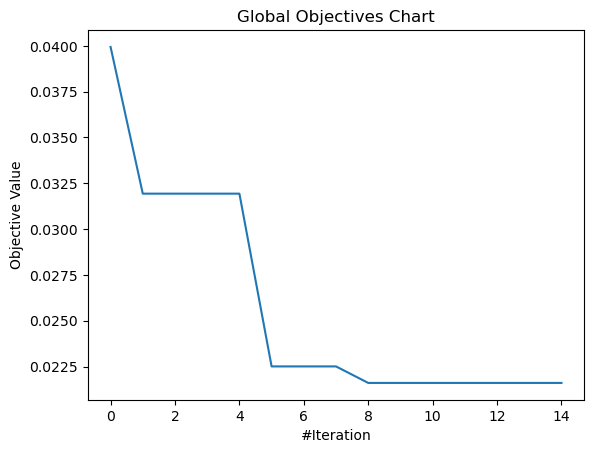

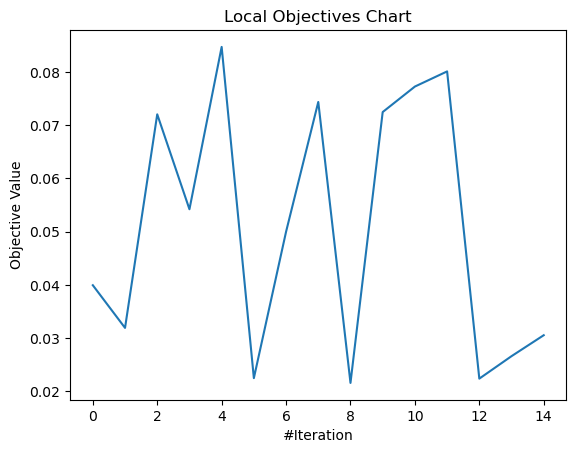

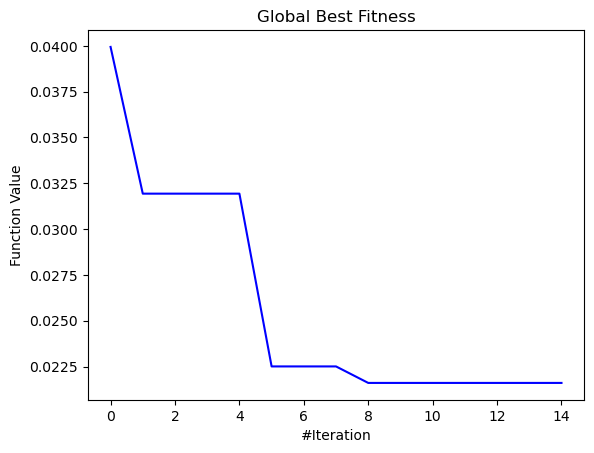

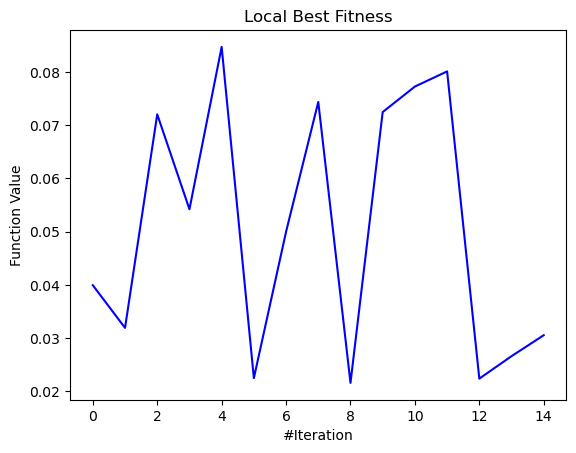

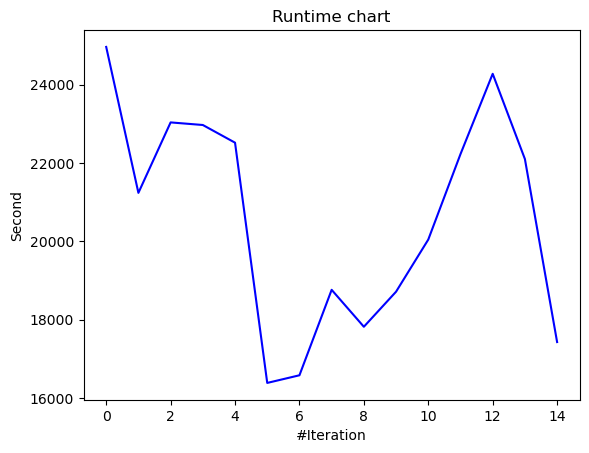

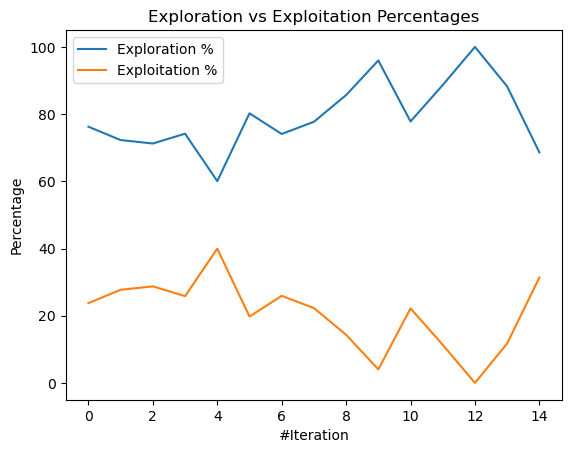

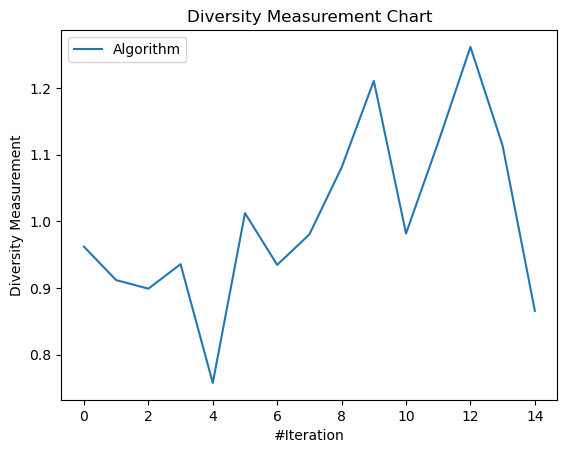

In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])

#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]

  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))


  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]
UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = FOX.OriginalFOX(epoch=15, pop_size=20)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="network-fox/goc")
model.history.save_local_objectives_chart(filename="network-fox/loc")

model.history.save_global_best_fitness_chart(filename="network-fox/gbfc")
model.history.save_local_best_fitness_chart(filename="network-fox/lbfc")

model.history.save_runtime_chart(filename="network-fox/rtc")

model.history.save_exploration_exploitation_chart(filename="network-fox/eec")

model.history.save_diversity_chart(filename="network-fox/dc")


Solution: [2.99 0.04034541 5.94147186 1.44130593 2.82863117], Fitness: 0.021606266498565674

Batch Size - 32, 64, **128**

Activation - **softmax**, softplus, relu, tanh, sigmoid, hard_sigmoid, linear

Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, **0.1**

Filters - 25, **50**, 75

Hidden Units - 400, 512, **640**

Model: "sequential_322"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_322 (Conv1D)         (None, 40, 50)            200       
                                                                 
 max_pooling1d_322 (MaxPool  (None, 20, 50)            0         
 ing1D)                                                          
                                                                 
 dropout_644 (Dropout)       (None, 20, 50)            0         
                                                                 
 batch_normalization_322 (B  (None, 20, 50)            200       
 atchNormalization)                                              
                                                                 
 lstm_322 (LSTM)             (None, 64)                29440     
                                                                 
 flatten_322 (Flatten)       (None, 64)             

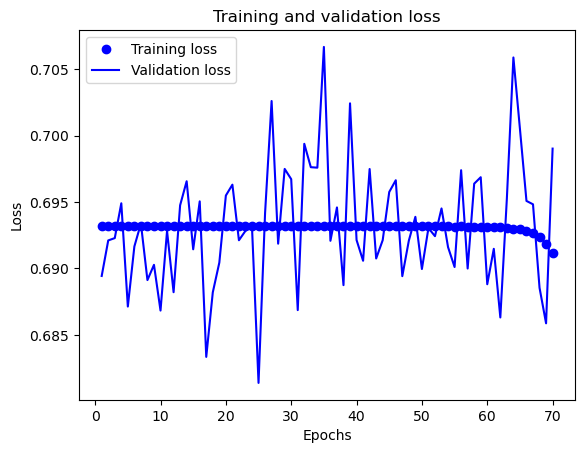

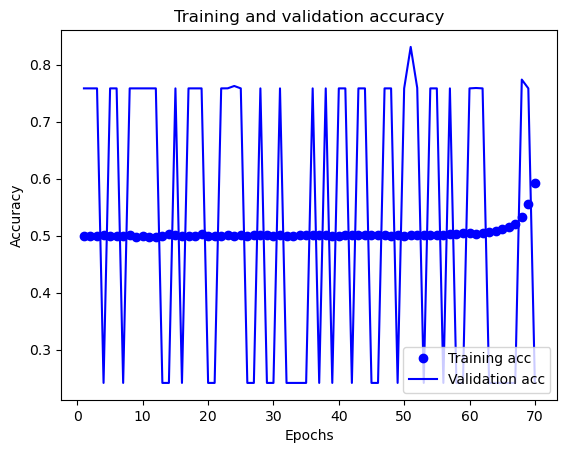


Classification Report
              precision    recall  f1-score   support

           0       0.23      1.00      0.38      4943
           1       0.00      0.00      0.00     16161

    accuracy                           0.23     21104
   macro avg       0.12      0.50      0.19     21104
weighted avg       0.05      0.23      0.09     21104


Confusion Matrix
[[ 4943     0]
 [16161     0]]


c:\Users\User1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


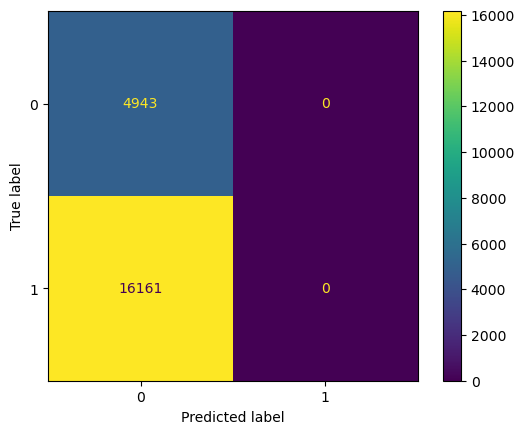

Time taken: 3720.2260 seconds


In [ ]:
start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(640, activation='softmax'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.1)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=128, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")